In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster

from utils import *

import warnings

warnings.filterwarnings("ignore")


from sklearn.cluster import AffinityPropagation    
def gen_spikepoints(data):
        return AffinityPropagation().fit(data).cluster_centers_


In [2]:
def run_pseudo_fed_eucl(data_path, n_participants=4):
    """
    Run pseudo federated Euclidean clustering on the data in data_path.
    """
    data = pd.read_csv(data_path, sep="\t", index_col=0)
    # num samples, num features
    data = data.T.to_numpy()

    real_dist_matrix = euclidean_distances(data)

    split_data = np.split(data, n_participants)

    spikepoints = [gen_spikepoints(split_data[i]) for i in range(n_participants)]

    global_spikepoints = np.concatenate(spikepoints)

    lsdms = [euclidean_distances(split_data[i], global_spikepoints) for i in range(n_participants)]
    fedm = euclidean_distances(np.concatenate(lsdms))

    regs = [regression_per_client(split_data[i], lsdms[i]) for i in range(n_participants)]

    Mx, Mc = construct_global_Mx_Cx_matrix(regs)

    pedm = calc_pred_dist_matrix(
        fedm=fedm,
        global_Mx=Mx,
        global_Cx=Mc,
    )
    # done runnning, do post proccessing:


    # make real dist matrix symmetric
    real_dist_matrix = (real_dist_matrix + real_dist_matrix.T) / 2
    # make pedm symmetric
    pedm = (pedm + pedm.T) / 2


    return data, real_dist_matrix, pedm, fedm


In [3]:
def plot_data_comparison(data_path, n_participants, n_clusters):
    data, real_dist_matrix, pedm, fedm = run_pseudo_fed_eucl(data_path)

    Z_real = linkage(squareform(real_dist_matrix), method='ward')
    Z_pedm = linkage(squareform(pedm), method='ward')
    clusters_real = fcluster(Z_real, n_clusters, criterion='maxclust')
    clusters_pedm = fcluster(Z_pedm, n_clusters, criterion='maxclust')

    data2d = PCA(n_components=2).fit_transform(data)


    # match the clusters with each other
    n_clusters = 5

    unique_clusters_real = np.unique(clusters_real)
    unique_clusters_pedm = np.unique(clusters_pedm)

    # get the cluster centers
    cluster_centers_real = []
    cluster_centers_pedm = []
    for i in unique_clusters_real:
        cluster_centers_real.append(np.mean(data2d[clusters_real == i], axis=0))
        cluster_centers_pedm.append(np.mean(data2d[clusters_pedm == i], axis=0))

    # get the distances between the cluster centers
    cluster_dists = euclidean_distances(cluster_centers_real, cluster_centers_pedm)

    # get the best matching
    best_matching = np.argmin(cluster_dists, axis=1)

    # switch cluster labels
    clauster_label_mapping = {
        i + 1: best_matching[i] + 1
        for i in range(n_clusters)
    }

    #colors = plt.colormaps['gist_ncar']
    colors = plt.cm.get_cmap('gist_ncar', n_clusters + 1)

    fig, ax = plt.subplots(ncols=2,figsize=(10, 8))

    for i in unique_clusters_real:
        color = colors(clauster_label_mapping[i] - 1)
        ax[0].scatter(data2d[clusters_real == i, 0], data2d[clusters_real == i, 1],color=color ,label="Cluster "+ str(clauster_label_mapping[i]), s=1)
    for i in unique_clusters_pedm:
        color = colors(i - 1)
        ax[1].scatter(data2d[clusters_pedm == i, 0], data2d[clusters_pedm == i, 1],color=color, label="Cluster "+str(i), s=1)
    ax[0].set_title("Real")
    ax[1].set_title("PEDM")
    plt.legend()

    plt.show()

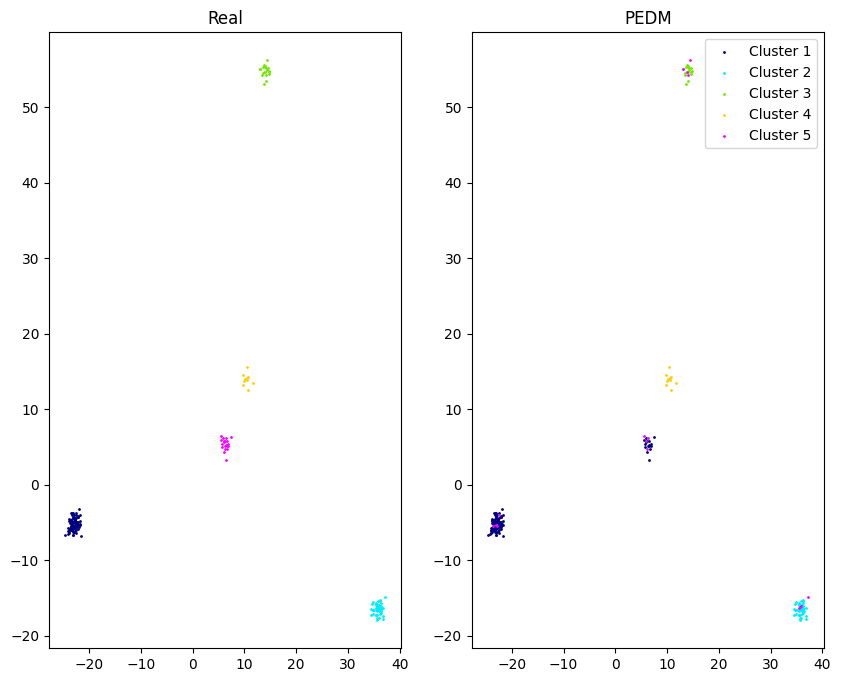

In [4]:
plot_data_comparison(
    "./simulatedData/simulated/A/A.n_genes=500,m=4,std=1,overlap=no.exprs_z.tsv",
    4,
    5
)

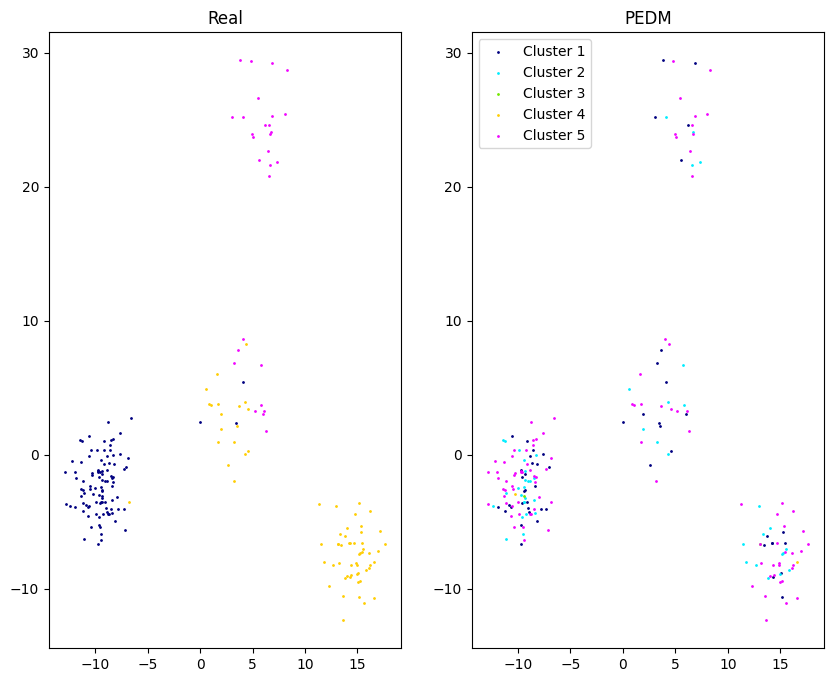

In [5]:
plot_data_comparison(
    "./simulatedData/simulated/A/A.n_genes=50,m=4,std=1,overlap=no.exprs_z.tsv",
    4,
    5
)

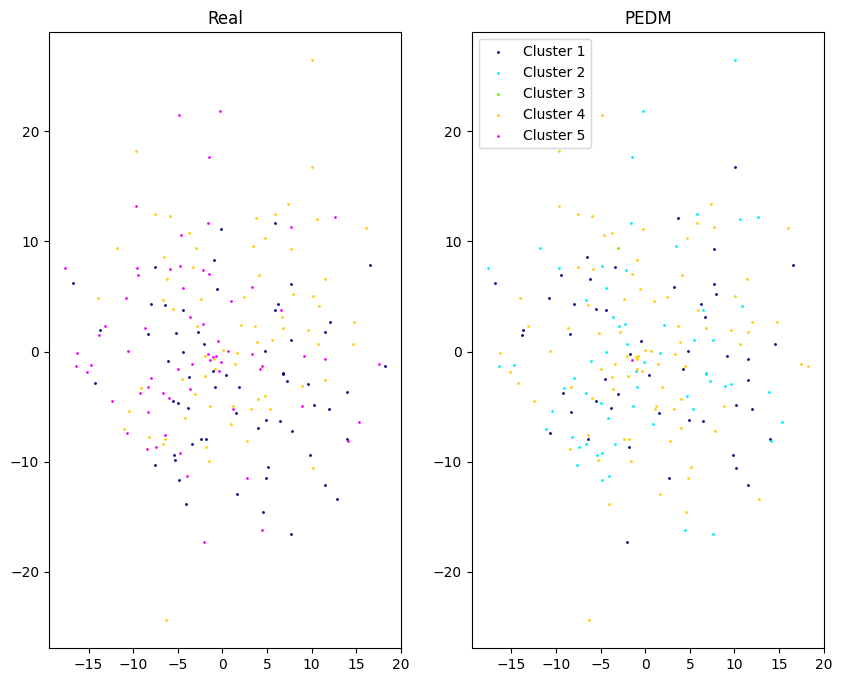

In [6]:
plot_data_comparison(
    "./simulatedData/simulated/A/A.n_genes=5,m=4,std=1,overlap=no.exprs_z.tsv",
    4,
    5
)